# Backtest code (new)

Loading YOUR single-index historical factor values from: alpha_data_values_1.csv
Data covers 83 assets from 2020-03-24 to 2025-03-21
Backtest Analysis Period: 2020-03-24 to 2025-03-24

Fetching price data for return calculation...
Price data fetched and forward returns calculated.

Aligning factor values and forward returns...
Alignment complete. Shape: (95087, 17)

--- Running Backtest Simulation for Each Factor ---


Backtesting Factors: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]



Fetching benchmark data...

--- Plotting and Saving Performance ---
Saved plot: backtest_plot_figure_1.png


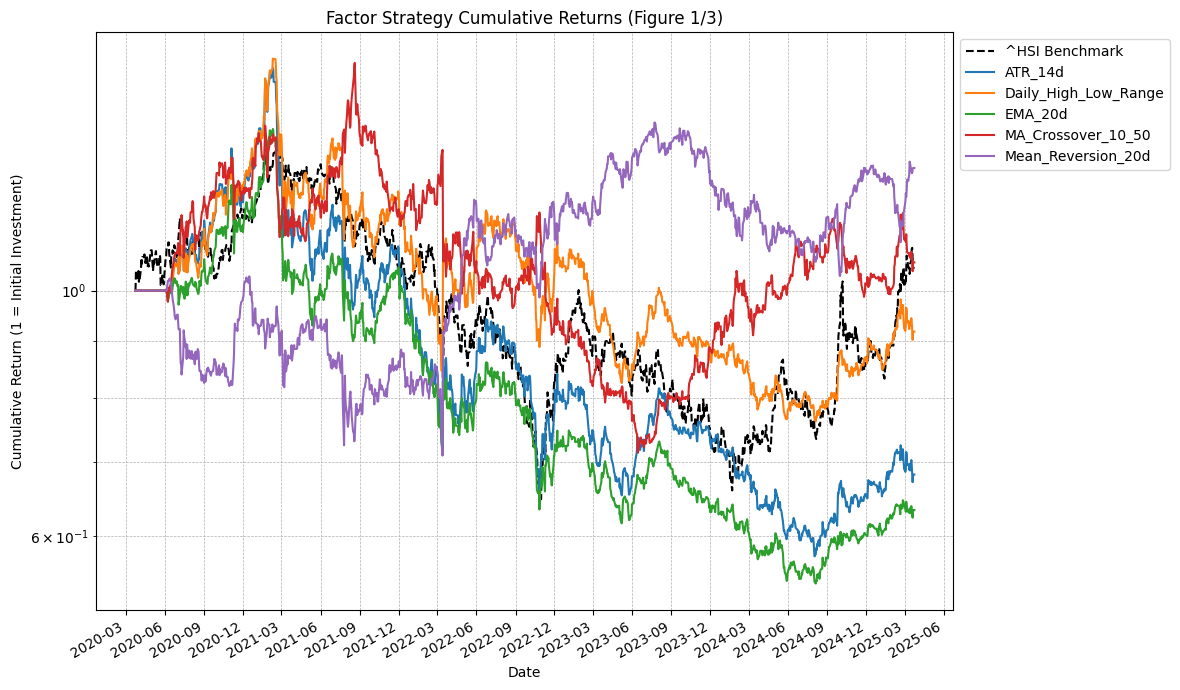

Saved plot: backtest_plot_figure_2.png


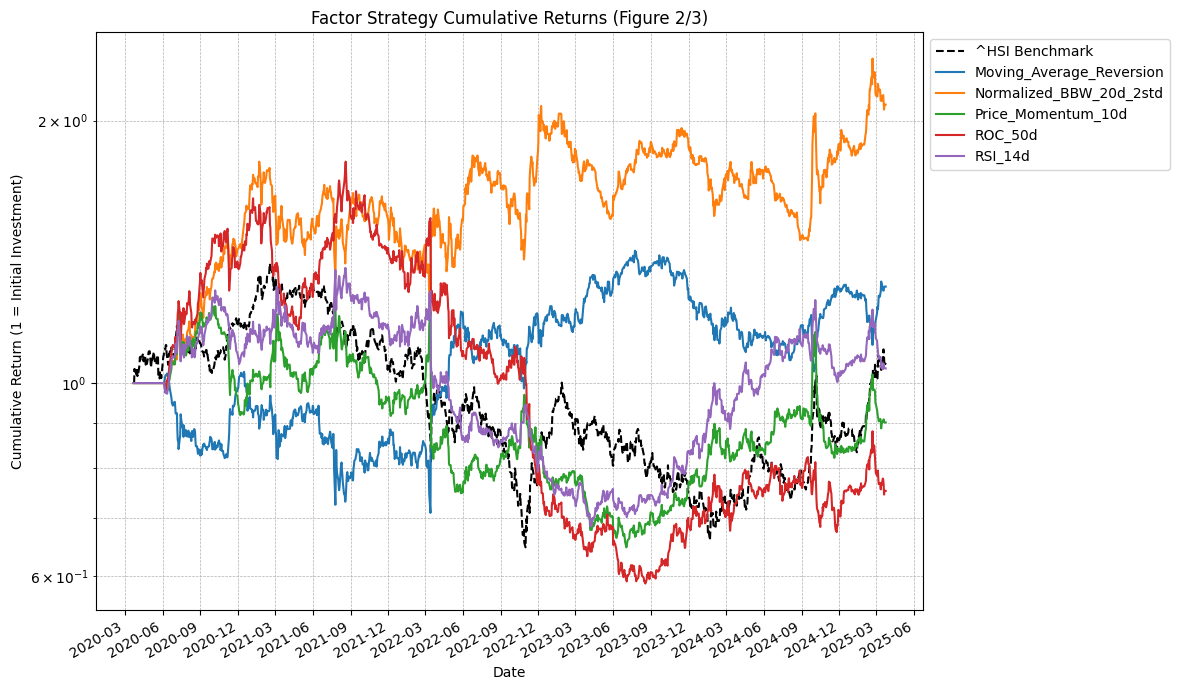

Saved plot: backtest_plot_figure_3.png


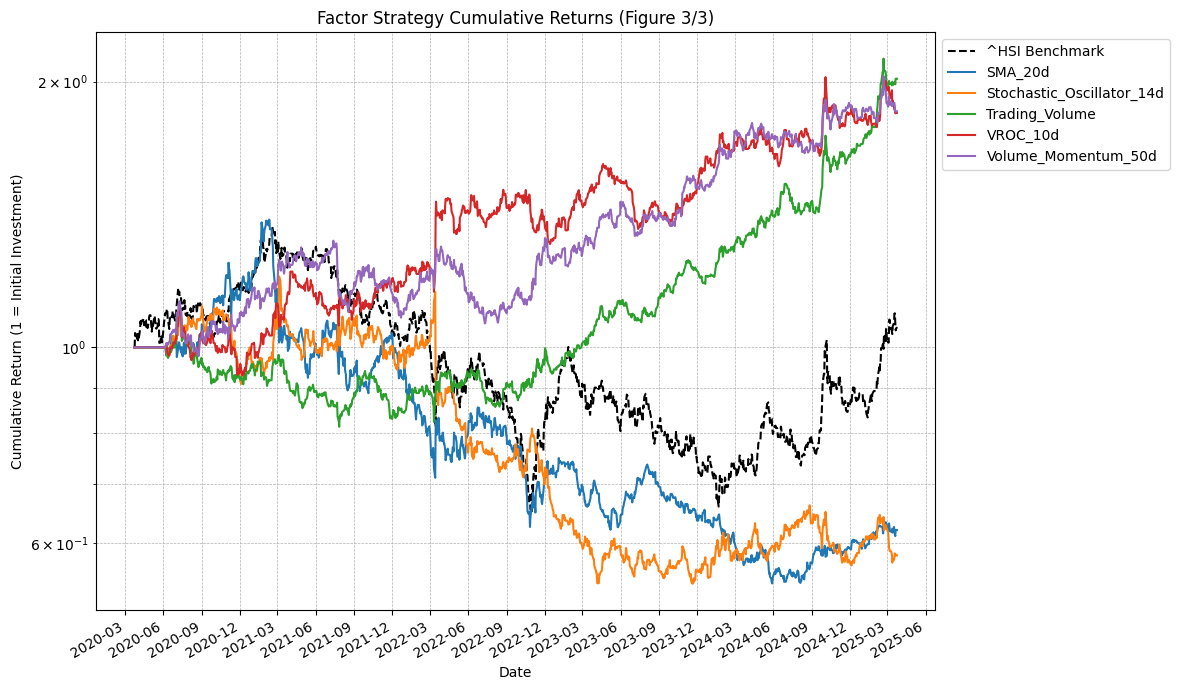


--- Performance Metrics Summary ---

Saving performance metrics to: backtest_performance_metrics.csv
Save successful.

--- Formatted Metrics for Display ---
                          Total Return Annualized Return  \
ATR_14d                        -31.77%            -7.36%   
Daily_High_Low_Range            -8.17%            -1.69%   
EMA_20d                        -36.62%            -8.72%   
MA_Crossover_10_50               6.04%             1.18%   
Mean_Reversion_20d              29.03%             5.23%   
Moving_Average_Reversion        29.03%             5.23%   
Normalized_BBW_20d_2std        108.64%            15.85%   
Price_Momentum_10d              -9.87%            -2.06%   
ROC_50d                        -24.78%            -5.54%   
RSI_14d                          3.95%             0.78%   
SMA_20d                        -37.91%            -9.09%   
Stochastic_Oscillator_14d      -41.88%           -10.29%   
Trading_Volume                 101.58%            15.05%   
VR

In [ ]:
# SCRIPT: BACKTESTING SIMULATION (Loading Single-Index Factor Values + SAVING OUTPUTS)

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from tqdm import tqdm
import os

# --- Configuration ---
USER_FACTOR_VALUES_CSV = "alpha_data_values_1.csv" # INPUT: Your pre-calculated factor values
STOCK_ID_COLUMN = 'stock_id'
DATE_COLUMN = 'Date'

BENCHMARK_TICKER = "^HSI"
START_DATE_STR = "2020-03-24"
END_DATE_STR = "2025-03-24"
PRICE_DATA_COLUMN = 'Close'
N_QUANTILES = 5
TOP_QUANTILE = N_QUANTILES
BOTTOM_QUANTILE = 1

# --- OUTPUT FILENAMES ---
PLOT_FILENAME_PREFIX = "backtest_plot_figure_" # Files will be like backtest_plot_figure_1.png
METRICS_FILENAME = "backtest_performance_metrics.csv"

# --- Load YOUR Factor Data (Single Index) ---
print(f"Loading YOUR single-index historical factor values from: {USER_FACTOR_VALUES_CSV}")
if not os.path.exists(USER_FACTOR_VALUES_CSV):
    print(f"FATAL ERROR: Factor values file not found: {USER_FACTOR_VALUES_CSV}")
    exit()
try:
    factor_values_df = pd.read_csv(
        USER_FACTOR_VALUES_CSV,
        parse_dates=[DATE_COLUMN],
        index_col=DATE_COLUMN
    )
    if 'Unnamed: 0' in factor_values_df.columns:
        factor_values_df.drop(columns=['Unnamed: 0'], inplace=True)
    if not isinstance(factor_values_df.index, pd.DatetimeIndex): raise ValueError("Index is not DatetimeIndex.")
    if STOCK_ID_COLUMN not in factor_values_df.columns: raise ValueError(f"Stock ID column '{STOCK_ID_COLUMN}' not found.")
    if factor_values_df.empty: raise ValueError("Loaded factor data is empty.")
    factor_values_df.sort_index(inplace=True)
    assets = [str(asset) for asset in factor_values_df[STOCK_ID_COLUMN].unique().tolist()]
    min_date_data = factor_values_df.index.min(); max_date_data = factor_values_df.index.max()
    print(f"Data covers {len(assets)} assets from {min_date_data.date()} to {max_date_data.date()}")
    print(f"Backtest Analysis Period: {START_DATE_STR} to {END_DATE_STR}")
except Exception as e: print(f"ERROR loading {USER_FACTOR_VALUES_CSV}: {e}"); exit()


# --- Fetch Price Data for Returns ---
print("\nFetching price data for return calculation...")
analysis_start_dt = datetime.strptime(START_DATE_STR, '%Y-%m-%d')
analysis_end_dt = datetime.strptime(END_DATE_STR, '%Y-%m-%d')
fetch_start = (analysis_start_dt - timedelta(days=5)).strftime('%Y-%m-%d')
fetch_end = (analysis_end_dt + timedelta(days=5)).strftime('%Y-%m-%d')
try:
    price_data_multi = yf.download(assets, start=fetch_start, end=fetch_end, progress=False, auto_adjust=False)
    if price_data_multi.empty: raise ValueError("No price data downloaded.")
    if isinstance(price_data_multi.columns, pd.MultiIndex): price_data = price_data_multi.xs(PRICE_DATA_COLUMN, level=0, axis=1)
    else:
         if PRICE_DATA_COLUMN in price_data_multi.columns: price_data = price_data_multi[[PRICE_DATA_COLUMN]]
         elif 'Close' in price_data_multi.columns: PRICE_DATA_COLUMN = 'Close'; price_data = price_data_multi[[PRICE_DATA_COLUMN]]
         else: raise ValueError(f"Price column ('{PRICE_DATA_COLUMN}' or 'Close') not found.")
    daily_returns = price_data.pct_change().shift(-1)
    returns_stacked = daily_returns.stack(); returns_stacked.index.names = ['date', STOCK_ID_COLUMN]; returns_stacked.name = 'fwd_ret_1d'
    returns_df = returns_stacked.reset_index()
    returns_df[STOCK_ID_COLUMN] = returns_df[STOCK_ID_COLUMN].astype(factor_values_df[STOCK_ID_COLUMN].dtype)
    returns_df.rename(columns={'date': DATE_COLUMN}, inplace=True)
    print("Price data fetched and forward returns calculated.")
except Exception as e: print(f"ERROR fetching price data: {e}"); exit()

# --- Align Factor Data and Returns using Merge ---
# ... (Alignment logic remains the same) ...
print("\nAligning factor values and forward returns...")
factor_values_analysis = factor_values_df.loc[START_DATE_STR:END_DATE_STR].copy()
factor_values_analysis.reset_index(inplace=True)
aligned_data = pd.merge(factor_values_analysis, returns_df, on=[DATE_COLUMN, STOCK_ID_COLUMN], how='inner')
aligned_data.set_index(DATE_COLUMN, inplace=True); aligned_data.sort_index(inplace=True)
aligned_data.dropna(inplace=True)
if aligned_data.empty: print("ERROR: No data remaining after aligning."); exit()
print(f"Alignment complete. Shape: {aligned_data.shape}")

# --- Backtest Each Factor ---
# ... (Quantile assignment, portfolio return calculation remains the same) ...
print("\n--- Running Backtest Simulation for Each Factor ---")
all_factor_returns = {}
performance_metrics_numeric = {} # Store numeric metrics here first
factor_columns = [col for col in aligned_data.columns if col not in [STOCK_ID_COLUMN, 'fwd_ret_1d']]
if not factor_columns: print("ERROR: No factor columns found."); exit()
grouped_by_date = aligned_data.groupby(aligned_data.index)

for factor_id in tqdm(factor_columns, desc="Backtesting Factors"):
    daily_portfolio_returns = []
    # ... (loop through dates, calculate quantiles, long/short returns, portfolio_ret_today) ...
    for date, group_today in grouped_by_date:
        try: quantiles_today = pd.qcut(group_today[factor_id], N_QUANTILES, labels=False, duplicates='drop') + 1
        except Exception: continue
        group_today = group_today.assign(quantile=quantiles_today)
        long_returns = group_today.loc[group_today['quantile'] == TOP_QUANTILE, 'fwd_ret_1d']
        short_returns = group_today.loc[group_today['quantile'] == BOTTOM_QUANTILE, 'fwd_ret_1d']
        long_ret_today = long_returns.mean() if not long_returns.empty else 0.0
        short_ret_today = short_returns.mean() if not short_returns.empty else 0.0
        portfolio_ret_today = long_ret_today - short_ret_today
        daily_portfolio_returns.append({'date': date, 'strategy_return': portfolio_ret_today})

    if not daily_portfolio_returns: continue # Skip factor if no returns calculated
    strategy_returns_df = pd.DataFrame(daily_portfolio_returns).set_index('date')
    date_range = pd.date_range(start=analysis_start_dt, end=analysis_end_dt, freq='B')
    strategy_returns_df = strategy_returns_df.reindex(date_range, fill_value=0.0)
    all_factor_returns[factor_id] = strategy_returns_df['strategy_return']

    # Calculate numeric performance metrics
    cumulative_returns = (1 + strategy_returns_df['strategy_return']).cumprod()
    if cumulative_returns.empty: continue
    total_return = cumulative_returns.iloc[-1] - 1
    n_years = (strategy_returns_df.index[-1] - strategy_returns_df.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 and total_return > -1 else 0.0
    annualized_vol = strategy_returns_df['strategy_return'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 1e-9 else 0.0 # Avoid division by zero or near-zero
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = drawdown.min()

    # Store numeric metrics
    performance_metrics_numeric[factor_id] = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Num Trading Days': len(strategy_returns_df)
    }


# --- Prepare Benchmark Data ---
# ... (Remains the same) ...
print("\nFetching benchmark data...")
try:
    bm_start = START_DATE_STR; bm_end = (analysis_end_dt + timedelta(days=1)).strftime('%Y-%m-%d')
    benchmark_data = yf.download(BENCHMARK_TICKER, start=bm_start, end=bm_end , progress=False)
    benchmark_returns = benchmark_data[PRICE_DATA_COLUMN].pct_change().dropna()
    benchmark_returns = benchmark_returns.reindex(date_range, fill_value=0.0) # Align to same date range
    benchmark_cumulative = (1 + benchmark_returns).cumprod()
except Exception as e: print(f"Warning: Could not fetch benchmark data {BENCHMARK_TICKER}: {e}"); benchmark_cumulative = None


# --- Plotting & SAVING PLOTS ---                  <-- MODIFICATION HERE
print("\n--- Plotting and Saving Performance ---")
num_factors = len(all_factor_returns)
if num_factors == 0: print("No factor returns to plot.")
else:
    plots_per_figure = 5; num_figures = int(np.ceil(num_factors / plots_per_figure))
    factor_ids_to_plot = list(all_factor_returns.keys())

    for fig_idx in range(num_figures):
        start_idx = fig_idx * plots_per_figure; end_idx = min((fig_idx + 1) * plots_per_figure, num_factors)
        current_factor_ids = factor_ids_to_plot[start_idx:end_idx]

        fig, ax = plt.subplots(figsize=(14, 7)) # Use fig, ax for object-oriented approach

        # Plot benchmark
        if benchmark_cumulative is not None:
            ax.plot(benchmark_cumulative.index, benchmark_cumulative, label=f'{BENCHMARK_TICKER} Benchmark', color='black', linestyle='--')

        # Plot strategies
        for factor_id in current_factor_ids:
            factor_return_series = all_factor_returns[factor_id]; cumulative_returns = (1 + factor_return_series).cumprod()
            # Prepend 1.0 for starting point
            cumulative_returns_plot = pd.concat([pd.Series([1.0], index=[cumulative_returns.index[0] - pd.Timedelta(days=1)]), cumulative_returns])
            ax.plot(cumulative_returns_plot.index, cumulative_returns_plot, label=f'{factor_id}')

        ax.set_title(f'Factor Strategy Cumulative Returns (Figure {fig_idx+1}/{num_figures})')
        ax.set_xlabel('Date'); ax.set_ylabel('Cumulative Return (1 = Initial Investment)')
        ax.set_yscale('log'); ax.legend(loc='upper left', bbox_to_anchor=(1, 1)); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')); ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        fig.autofmt_xdate(); plt.tight_layout(rect=[0, 0, 0.85, 1])

        # --- SAVE THE PLOT ---
        plot_filename = f"{PLOT_FILENAME_PREFIX}{fig_idx+1}.png"
        try:
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            print(f"Saved plot: {plot_filename}")
        except Exception as e_save_plot:
            print(f"ERROR saving plot {plot_filename}: {e_save_plot}")

        plt.show() # Show plot after saving
        plt.close(fig) # Close the figure to free memory


# --- SAVING & Display Performance Metrics ---      <-- MODIFICATION HERE
print("\n--- Performance Metrics Summary ---")
if performance_metrics_numeric:
    # Create DataFrame from numeric metrics
    perf_df_numeric = pd.DataFrame.from_dict(performance_metrics_numeric, orient='index')

    # --- SAVE NUMERIC METRICS TO CSV ---
    print(f"\nSaving performance metrics to: {METRICS_FILENAME}")
    try:
        perf_df_numeric.to_csv(METRICS_FILENAME, index=True, index_label='Factor_ID')
        print("Save successful.")
    except Exception as e_save_metrics:
        print(f"ERROR saving metrics CSV {METRICS_FILENAME}: {e_save_metrics}")
    # --- END SAVE ---

    # Create formatted DataFrame for display ONLY
    perf_df_formatted = perf_df_numeric.copy()
    perf_df_formatted['Total Return'] = perf_df_formatted['Total Return'].map('{:.2%}'.format)
    perf_df_formatted['Annualized Return'] = perf_df_formatted['Annualized Return'].map('{:.2%}'.format)
    perf_df_formatted['Annualized Volatility'] = perf_df_formatted['Annualized Volatility'].map('{:.2%}'.format)
    perf_df_formatted['Sharpe Ratio'] = perf_df_formatted['Sharpe Ratio'].map('{:.2f}'.format)
    perf_df_formatted['Max Drawdown'] = perf_df_formatted['Max Drawdown'].map('{:.2%}'.format)
    # Keep Num Trading Days as integer
    perf_df_formatted['Num Trading Days'] = perf_df_formatted['Num Trading Days'].map('{:.0f}'.format)

    print("\n--- Formatted Metrics for Display ---")
    print(perf_df_formatted)

else:
    print("No performance metrics calculated.")

print("\n--- Backtesting Script Finished ---")

# Agent for summarizing up-to-date market information

In [4]:
!pip install langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 291.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.0/186.0 kB 647.9 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.4/423.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.8/352.8 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 872.3 kB/s eta 0:00:00 0:0

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# SCRIPT 2: MARKET INFORMATION SUMMARIZATION (Fixed Date Range: 2020-2025)

import json
import time
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from langchain_community.llms import Ollama
# from ollama import Client # Using Langchain wrapper
import traceback

# --- Configuration ---
HSI_VOLATILITY_FILES = [ # List of your HSI Volatility CSV file paths
    'HSI Volatility Historical Data_1.csv',
    'HSI Volatility Historical Data_2.csv',
    'HSI Volatility Historical Data_3.csv'
]
HSI_INDEX_TICKER = '^HSI'  # Ticker symbol for Hang Seng Index
LLM_MODEL = "llama4:latest"      # Ollama model to use
MAX_LLM_RETRIES = 3         # Max retries for the LLM call
LLM_RETRY_DELAY = 5         # Seconds to wait between retries

# --- FIXED DATE RANGE ---
START_DATE_STR = "2020-03-24"
END_DATE_STR = "2025-03-24"

# --- Function Definition ---

def get_market_summary_from_llm_fixed_period( # Renamed function slightly
    hsi_volatility_paths: list,
    hsi_index_ticker: str,
    start_date: str = START_DATE_STR, # Use fixed start date
    end_date: str = END_DATE_STR,     # Use fixed end date
    max_retries: int = MAX_LLM_RETRIES,
    retry_delay: int = LLM_RETRY_DELAY
) -> str | None:
    """
    Fetches and summarizes Hong Kong market information for a FIXED period using an LLM.

    Args:
        hsi_volatility_paths (list): List of file paths for HSI Volatility Index CSVs.
        hsi_index_ticker (str): Ticker symbol for the Hang Seng Index (e.g., '^HSI').
        start_date (str): The start date for the data period (YYYY-MM-DD).
        end_date (str): The end date for the data period (YYYY-MM-DD).
        max_retries (int): Maximum number of retries for the LLM call.
        retry_delay (int): Delay in seconds between retries.

    Returns:
        str: The summarized market information from the LLM, or None if an error occurs.
    """
    print(f"--- Preparing Data for Market Summary ({start_date} to {end_date}) ---")
    hsi_volatility_df_period = None
    hsi_index_df_period = None

    # 1. Load and Process HSI Volatility Index Data for the fixed period
    try:
        hsi_volatility_dfs = []
        for path in hsi_volatility_paths:
            if os.path.exists(path):
                 try:
                      df = pd.read_csv(path)
                      date_col = next((col for col in df.columns if col.lower() == 'date'), None)
                      if date_col:
                           df.rename(columns={date_col: 'Date'}, inplace=True)
                           df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                           hsi_volatility_dfs.append(df.dropna(subset=['Date']))
                      else: print(f"Warning: 'Date' column not found in {path}.")
                 except Exception as e_csv: print(f"Warning: Could not read/process {path}: {e_csv}")
            else: print(f"Warning: HSI Volatility file not found: {path}")

        if not hsi_volatility_dfs:
             print("Warning: No valid HSI Volatility data loaded.")
        else:
            hsi_volatility_df = pd.concat(hsi_volatility_dfs, ignore_index=True)
            # Set Date as index, sort, keep most recent duplicate
            hsi_volatility_df = hsi_volatility_df.set_index('Date').sort_index()
            hsi_volatility_df = hsi_volatility_df[~hsi_volatility_df.index.duplicated(keep='last')]
            # *** Filter using .loc on the DatetimeIndex for the fixed period ***
            hsi_volatility_df_period = hsi_volatility_df.loc[start_date:end_date]
            print(f"Processed HSI Volatility data for period. Shape: {hsi_volatility_df_period.shape}")
            if hsi_volatility_df_period.empty:
                 print("Warning: No HSI Volatility data found within the specified date range.")


    except Exception as e_vol:
        print(f"Error processing HSI Volatility data: {e_vol}")


    # 2. Fetch Hang Seng Index Data for the fixed period
    try:
        # Use the fixed start and end dates for yfinance download
        # yfinance end date is exclusive, so add one day to include the end_date
        end_date_fetch = (datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

        hsi_index_df = yf.download(
            hsi_index_ticker,
            start=start_date,
            end=end_date_fetch,
            progress=False,
            auto_adjust=False
        )
        if hsi_index_df.empty:
            print(f"Warning: No HSI data downloaded ({hsi_index_ticker}) for the period.")
        else:
            # Filter again just to be sure it matches exact range (yf might give slightly different bounds)
            hsi_index_df_period = hsi_index_df.loc[start_date:end_date].reset_index()
            print(f"Fetched HSI data for period. Shape: {hsi_index_df_period.shape}")
            if hsi_index_df_period.empty:
                 print("Warning: No HSI Index data found within the specified date range after filtering.")

    except Exception as e_hsi:
        print(f"Error fetching HSI data ({hsi_index_ticker}): {e_hsi}")


    # 3. Construct Prompt (using data from the fixed period)
    print("\n--- Constructing Prompt for LLM ---")

    prompt_parts = [
        "You are a financial analyst providing up-to-date market information for Hong Kong.",
        "Based *only* on the following recent data, summarize the current market trends, sentiment, volatility, and potential short-term outlook comprehensively.",
        "Provide quantitative and qualitative financial insights about Hang Seng Index (or any implication for the stocks under Hang Sang Index) comprehensively. Be objective. Do not include any disclaimers or conversational text.",
        "Just do the quantitative and qualitative financial analysis. Do not generate any Python code."
    ]

    # Add HSI Volatility data for the period if available
    if hsi_volatility_df_period is not None and not hsi_volatility_df_period.empty:
        prompt_parts.append(f"\n\nHSI Volatility Index Data ({start_date} to {end_date}):")
        prompt_parts.append(hsi_volatility_df_period.to_string()) # Sends potentially large string
    else:
        prompt_parts.append("\n\n(HSI Volatility Index Data was not available for the specified period)")

    # Add HSI Index data for the period if available
    if hsi_index_df_period is not None and not hsi_index_df_period.empty:
        prompt_parts.append(f"\n\nHang Seng Index Data ({start_date} to {end_date}):")
        prompt_parts.append(hsi_index_df_period.to_string()) # Sends potentially large string
    else:
        prompt_parts.append("\n\n(Hang Seng Index Data was not available for the specified period)")

    # Check if any data is actually being sent
    if (hsi_volatility_df_period is None or hsi_volatility_df_period.empty) and \
       (hsi_index_df_period is None or hsi_index_df_period.empty):
         print("ERROR: No data available within the specified period to send to LLM.")
         return None

    final_prompt = "\n".join(prompt_parts)
    # Optional Debug: Check prompt size
    # print(f"DEBUG: Prompt length: {len(final_prompt)} characters")


    # 4. Call LLM with Retry Logic
    print(f"\n--- Calling LLM for Market Summary ---")
    llm = Ollama(model=LLM_MODEL)
    last_exception = None

    for attempt in range(max_retries):
        try:
            response = llm.invoke(final_prompt)
            print("LLM call successful.")
            return response
        except Exception as e_llm:
            last_exception = e_llm
            print(f"Warning: LLM call attempt {attempt + 1}/{max_retries} failed: {e_llm}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Error: LLM call failed after maximum retries.")
                # traceback.print_exc() # Uncomment for detailed traceback
                return None

    return None # Should not be reached


# --- Main Execution ---
if __name__ == "__main__":
    print('--- Running Script 2: Get Market Information (Fixed Period) ---')

    # --- Call the function with fixed dates implicitly used from defaults ---
    market_summary = get_market_summary_from_llm_fixed_period(
        hsi_volatility_paths=HSI_VOLATILITY_FILES,
        hsi_index_ticker=HSI_INDEX_TICKER
        # start_date and end_date will use the defaults defined in the function
    )

    # --- Display Result ---
    if market_summary:
        print("\n✅ --- Market Information Summary Retrieved ---")
        print(market_summary)
        # Optional: Save summary
        summary_filename = f"market_summary_fixed_{START_DATE_STR}_to_{END_DATE_STR}.txt"
        with open(summary_filename, 'w', encoding='utf-8') as f: f.write(market_summary)
        print(f"\nSummary saved to {summary_filename}")
    else:
        print("\n❌ --- Could not retrieve market information ---")

    print('\n--- Script 2 Finished ---')

--- Running Script 2: Get Market Information (Fixed Period) ---
--- Preparing Data for Market Summary (2020-03-24 to 2025-03-24) ---
Processed HSI Volatility data for period. Shape: (1228, 6)
Fetched HSI data for period. Shape: (1229, 7)

--- Constructing Prompt for LLM ---

--- Calling LLM for Market Summary ---
LLM call successful.

✅ --- Market Information Summary Retrieved ---
This is a large dataset of daily highs and lows in stock market prices, starting from February 3, 2025, and ending on March 24, 2025. The data is presented in a comma-separated value (CSV) format.

To provide meaningful insights or analysis, I would need to know more about the context of this data. Is it related to a specific stock, industry, or market? Are there any specific questions or topics you'd like me to explore?

However, I can attempt to provide some general observations and trends based on the data:

1. **Volatility**: The dataset exhibits significant volatility in price movements, with both high h

# Collection of K-line charts

In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [15]:
# SCRIPT 3: Collecting all K-line charts for each stock in png file and put them into one directory
import yfinance as yf
import plotly.graph_objects as go
import os # <-- Import the os module
import pandas as pd # <-- Import pandas for isinstance check

# --- Configuration ---
OUTPUT_DIR = "candlestick_charts" # Directory to save charts
CHART_PERIOD = "5y"
CHART_INTERVAL = "1d"
# -------------------

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Charts will be saved in: {os.path.abspath(OUTPUT_DIR)}")

def create_kline_chart(ticker, period="1mo", interval="1d"):
    """
    Downloads stock data and creates a Plotly Candlestick figure object.

    Args:
        ticker (str): The stock ticker symbol.
        period (str): The period for which to download data (e.g., "1mo", "1y", "5y").
        interval (str): The data interval (e.g., "1d", "1wk", "1mo").

    Returns:
        plotly.graph_objects.Figure or None: The generated figure object,
                                             or None if an error occurs or no data is found.
    """
    print(f"Attempting to download data for {ticker} ({period}, {interval})...")
    try:
        # Use actions=False to potentially avoid issues with splits/dividends altering dates slightly
        data = yf.download(tickers=ticker, period=period, interval=interval, progress=False, actions=False)

        if data is None: # Check if yfinance returned None
            print(f"yfinance returned None for {ticker}. Check ticker, period, and interval.")
            return None # <-- Return None on failure

        if data.empty:
            print(f"No data found for {ticker} with the specified period '{period}' and interval '{interval}'.")
            return None # <-- Return None if no data

        # When downloading a single ticker, yfinance might not use a MultiIndex
        # We need to handle both MultiIndex and single Index columns
        if isinstance(data.columns, pd.MultiIndex):
            # Flatten the MultiIndex if present
            data.columns = [' '.join(col).strip() for col in data.columns.values]
             # Construct column names dynamically based on the actual ticker downloaded
             # Needed because yfinance might return slightly different names sometimes
            open_col = f'Open {ticker}' if f'Open {ticker}' in data.columns else 'Open'
            high_col = f'High {ticker}' if f'High {ticker}' in data.columns else 'High'
            low_col = f'Low {ticker}' if f'Low {ticker}' in data.columns else 'Low'
            close_col = f'Close {ticker}' if f'Close {ticker}' in data.columns else 'Close'
        else:
            # Handle single index case (columns are likely 'Open', 'High', etc.)
            open_col = 'Open'
            high_col = 'High'
            low_col = 'Low'
            close_col = 'Close'

        # Verify that the essential columns exist
        required_cols = [open_col, high_col, low_col, close_col]
        if not all(col in data.columns for col in required_cols):
            print(f"Error: Expected columns {required_cols} not found for {ticker}. Found columns: {data.columns.tolist()}")
            return None


        # print(f"Data for {ticker} processed successfully.") # Optional: uncomment for debugging

        fig = go.Figure(data=[go.Candlestick(x=data.index,
                                             open=data[open_col],
                                             high=data[high_col],
                                             low=data[low_col],
                                             close=data[close_col])])

        fig.update_layout(title=f'{ticker} Candlestick Chart ({interval}, {period})',
                          yaxis_title='Price',
                          xaxis_title='Date',
                          xaxis_rangeslider_visible=False) # Keep slider off for cleaner static image

        # fig.show()  # <-- We don't show it here anymore
        return fig  # <-- RETURN the figure object instead

    except Exception as e:
        print(f"An error occurred processing {ticker}: {e}")
        return None # <-- Return None on exception

# --- Main Execution Logic ---
tickers = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK',
                  "0322.HK", '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK',
                  "0992.HK", "1024.HK", '1038.HK', '1044.HK', '1088.HK', "1093.HK", '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK',
                  '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK',
                  '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK'] # Your list

print(f"\nStarting chart generation for {len(tickers)} tickers...")

for ticker in tickers:
    print("-" * 20)
    # Call the function to get the figure object
    fig = create_kline_chart(ticker, period=CHART_PERIOD, interval=CHART_INTERVAL)

    # Check if a valid figure was returned
    if fig:
        # Define filename and full path
        # Replace potential invalid filename characters if needed, though tickers usually are safe
        safe_ticker_name = ticker.replace(':', '_').replace('/', '_')
        filename = f"{safe_ticker_name}_{CHART_PERIOD}_{CHART_INTERVAL}.png"
        filepath = os.path.join(OUTPUT_DIR, filename)

        try:
            # Save the figure as a PNG image
            print(f"Saving chart for {ticker} to {filepath}...")
            fig.write_image(filepath, scale=2) # scale=2 increases resolution
            print(f"Successfully saved {filepath}")
        except ValueError as ve:
             print(f"Error saving chart for {ticker}: {ve}")
             print("Ensure you have the 'kaleido' package installed (`pip install -U kaleido`)")
             print("Alternatively, try installing 'plotly-orca'.")
             # Break or continue depending on desired behavior if saving fails
             # break
        except Exception as e:
            print(f"An unexpected error occurred while saving chart for {ticker} to {filepath}: {e}")
    else:
        # The function returned None, indicating an error or no data
        print(f"Skipping save for {ticker} due to issues during chart creation.")

print("-" * 20)
print("\nFinished processing all tickers.")

Charts will be saved in: /Users/alanto/Downloads/EMIA-03/Phase 2/candlestick_charts

Starting chart generation for 83 tickers...
--------------------
Attempting to download data for 0001.HK (5y, 1d)...
YF.download() has changed argument auto_adjust default to True
Saving chart for 0001.HK to candlestick_charts/0001.HK_5y_1d.png...
Successfully saved candlestick_charts/0001.HK_5y_1d.png
--------------------
Attempting to download data for 0002.HK (5y, 1d)...
Saving chart for 0002.HK to candlestick_charts/0002.HK_5y_1d.png...
Successfully saved candlestick_charts/0002.HK_5y_1d.png
--------------------
Attempting to download data for 0003.HK (5y, 1d)...
Saving chart for 0003.HK to candlestick_charts/0003.HK_5y_1d.png...
Successfully saved candlestick_charts/0003.HK_5y_1d.png
--------------------
Attempting to download data for 0005.HK (5y, 1d)...
Saving chart for 0005.HK to candlestick_charts/0005.HK_5y_1d.png...
Successfully saved candlestick_charts/0005.HK_5y_1d.png
--------------------

# News data

In [4]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Script 4: Collecting social media data
import requests
from bs4 import BeautifulSoup
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# HSI companies (expand this list as needed)
hsi_companies = {
    "0001.HK": "CK Hutchison Holdings",
    "0002.HK": "CLP Holdings",
    "0003.HK": "HK & China Gas",
    "0005.HK": "HSBC Holdings",
    "0006.HK": "Power Assets",
    "0011.HK": "Hang Seng Bank",
    "0012.HK": "Henderson Land",
    "0016.HK": "SHK PPT",
    "0101.HK": "Hang Lung Properties",
    "0188.HK": "BOC Hong Kong",
    "0270.HK": "China Life",
    "0386.HK": "Sinopec",
    "0388.HK": "HKEX",
    "0669.HK": "Techtronic Industries",
    "0700.HK": "Tencent",
    "0857.HK": "PetroChina",
    "0968.HK": "Xinyi Glass",
    "1299.HK": "AIA",
    "1336.HK": "ICBC",
    "1398.HK": "Bank of China",
    "2318.HK": "Ping An Insurance",
    "2388.HK": "BOC Hong Kong",
    "2628.HK": "China Life",
    "3968.HK": "CM Bank",
    "3988.HK": "Bank of China",
    "0004.HK": "Li & Fung",
    "0688.HK": "China Overseas",
    "0823.HK": "Link REIT",
    "1109.HK": "CK Asset",
    "1113.HK": "China Resources Land",
    "1766.HK": "Galaxy Entertainment",
    "1988.HK": "China Merchants Bank",
    "2015.HK": "Li Auto",
    "2020.HK": "ANTA Sports",
    "3689.HK": "Beijing Capital",
    "3690.HK": "Meituan",
    "3692.HK": "HANSOH Pharma",
    "6618.HK": "JD Health",
    "6678.HK": "Haier Smart Home",
    "6690.HK": "Haier Smart Home",
    "678.HK": "Dingdong",
    "6862.HK": "Haidilao",
    "6881.HK": "China Pacific Insurance",
    "9898.HK": "Baidu",
    "9940.HK": "New Oriental",
    # Add any additional tickers if available...
}
# Function to scrape news from Google News
def scrape_news(companies, start_date, end_date):
    news_data = []
    current_date = start_date
    
    while current_date <= end_date:
        for ticker, company in companies.items():
            try:
                url = f"https://www.google.com/search?q={company.replace(' ', '+')}+news&tbs=cdr:1,cd_min:{current_date.strftime('%m/%d/%Y')},cd_max:{current_date.strftime('%m/%d/%Y')}&tbm=nws"
                headers = {
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
                }
                response = requests.get(url, headers=headers)
                response.raise_for_status()
                
                soup = BeautifulSoup(response.text, "html.parser")
                articles = soup.select("div[role='heading']")  # Capture the relevant articles
                
                if not articles:
                    print(f"No articles found for {company} on {current_date}.")
                    continue
                
                for article in articles:
                    title = article.text.strip()
                    sentiment = analyzer.polarity_scores(title)["compound"]
                    news_data.append({
                        "ticker": ticker,
                        "title": title,
                        "sentiment": sentiment,
                        "date": current_date.strftime("%Y-%m-%d")
                    })
                    
                print(f"News scraped for {company} on {current_date}: {len(articles)} articles found.")
            except Exception as e:
                print(f"Error scraping news for {company} on {current_date}: {e}")
        
        current_date += timedelta(days=7)  # Move to the next day

    return news_data

# Define the date range
start_date = datetime.strptime("2020-03-24", "%Y-%m-%d")
end_date = datetime.strptime("2025-03-24", "%Y-%m-%d")

# Scrape news
news_data = scrape_news(hsi_companies, start_date, end_date)

# Save to CSV
if news_data:
    df = pd.DataFrame(news_data)
    df.to_csv("hsi_scraped_news_2020_2025.csv", index=False)
    print(f"Saved data for {len(df)} articles")
else:
    print("No news data to save.")

# Load the remaining data needed

In [8]:
# Loaded the remaining datasets
import pandas as pd

try:
    hsi_financial_data_df = pd.read_csv('hsi_financial_data.csv')
    hsi_market_data_df = pd.read_csv('hsi_market_data_2020_2025.csv')
    hsi_scraped_news_df = pd.read_csv('hsi_scraped_news_2020_2025 (1).csv')
    hsi_company_profiles_df = pd.read_csv('hsi_company_profiles.csv')
    hsi_insider_transactions_df = pd.read_csv('hsi_insider_transactions.csv')

except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"An error occurred during loading: {e}")


# Integrated data to multi-agents

In [ ]:
pip install ollama pandas langchain langchain-community

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# -*- coding: utf-8 -*-
import ollama
import json
import datetime
import logging
import pandas as pd
import os
import re
import base64
from pathlib import Path
# Removed PIL/Image/io - not directly called.
import time

# Langchain imports (Conditional)
try:
    from langchain.output_parsers import StructuredOutputParser, ResponseSchema, OutputFixingParser
    from langchain.prompts import PromptTemplate
    from langchain_community.chat_models import ChatOllama
    LANGCHAIN_AVAILABLE = True
except ImportError:
    logging.warning("Langchain components not found. Output parsing will be basic JSON.")
    LANGCHAIN_AVAILABLE = False
    # Dummy classes
    class StructuredOutputParser:
        @staticmethod
        def from_response_schemas(schemas): return None
        def get_format_instructions(self): return "Output as JSON list: [{'alpha_name':..., 'confidence_score':..., 'reasoning':...}]"
        def parse(self, text):
            try: return json.loads(text)
            except: return {"error": "Langchain not available & basic JSON failed", "raw": text}
    class ResponseSchema:
        def __init__(self, name, description): pass
    class OutputFixingParser:
        def __init__(self, parser): self.parser = parser
        @staticmethod
        def from_llm(llm, parser, max_retries): return OutputFixingParser(parser)
        def parse(self, text):
             if self.parser: return self.parser.parse(text)
             else: return {"error": "Langchain not available", "raw": text}
    class PromptTemplate:
         def __init__(self, template, input_variables, **kwargs):
             self.template = template
             self.input_variables = input_variables
             self.partial_variables = kwargs.get('partial_variables', {})
         def format(self, **kwargs):
             all_vars = {**self.partial_variables, **kwargs}
             formatted = self.template
             for key, value in all_vars.items():
                  formatted = formatted.replace(f"{{{key}}}", str(value))
             if 'format_instructions' in self.partial_variables and '{format_instructions}' in self.template:
                  formatted = formatted.replace('{format_instructions}', str(self.partial_variables['format_instructions']))
             return formatted
    class ChatOllama:
        def __init__(self, model): self.model = model

# --- Logging Setup ---
run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir_base = Path("logs")
output_dir_base = Path("results")
CONFIG_LOG_DIR = log_dir_base / f"run_{run_timestamp}"
CONFIG_OUTPUT_DIR = output_dir_base / f"run_{run_timestamp}"

# Ensure directories exist
CONFIG_LOG_DIR.mkdir(parents=True, exist_ok=True)
CONFIG_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Setup logging configuration
log_file_path = CONFIG_LOG_DIR / f"main_run_{run_timestamp}.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file_path, encoding='utf-8'), # Specify encoding
        logging.StreamHandler()
    ]
)
# --- Configuration ---
CONFIG = {
    "MODEL_NAME": "llama4:latest",
    "DATA_DIR": ".",
    # --- Input Data Files ---
    "FINANCIAL_DATA_FILE": "hsi_financial_data.csv",
    "MARKET_DATA_FILE": "hsi_market_data_2020_2025.csv",
    "NEWS_DATA_FILE": "hsi_scraped_news_2020_2025 (1).csv",
    "PROFILES_DATA_FILE": "hsi_company_profiles.csv",
    "INSIDER_TX_DATA_FILE": "hsi_insider_transactions.csv",
    "SUMMARY_FILE": "market_summary_fixed_2020-03-24_to_2025-03-24.txt",
    "ALPHA_FACTOR_INPUT_FILE": "HK_final_comprehensive_result_3.csv",
    # --- Chart Directory ---
    "CHART_DIR": "candlestick_charts",
    # --- Final Output File ---
    "FINAL_ALPHA_FACTOR_OUTPUT_FILE": CONFIG_OUTPUT_DIR / f"all_selected_alpha_factors_{run_timestamp}.csv",
    # --- Optional Settings ---
    "API_CALL_DELAY_SECONDS": 0.5,
    "MAX_ROWS_SUMMARY": 30,
    "MAX_NEWS_SUMMARY": 20
}

# --- Helper Functions ---

def load_data(file_path, file_type="csv", data_dir=CONFIG["DATA_DIR"], **kwargs):
    """Loads data from a file (CSV or TXT)."""
    logger = logging.getLogger("load_data")
    full_path = Path(data_dir) / file_path
    if not full_path.exists():
         logger.error(f"File not found: {full_path}")
         return None
    try:
        if file_type == "csv":
            encodings_to_try = ['utf-8', 'latin1', 'cp950'] # Common encodings for HK data
            df = None
            for enc in encodings_to_try:
                try:
                    date_cols = kwargs.get('parse_dates', None) # Use get to avoid modifying kwargs
                    infer_datetime_format = kwargs.get('infer_datetime_format', True)
                    # Pass kwargs explicitly to read_csv
                    current_kwargs = kwargs.copy()
                    current_kwargs.pop('parse_dates', None) # Remove keys handled manually
                    current_kwargs.pop('infer_datetime_format', None)

                    df = pd.read_csv(full_path, encoding=enc, **current_kwargs)

                    if date_cols:
                        cols_to_parse = date_cols if isinstance(date_cols, list) else [date_cols]
                        if isinstance(date_cols, bool) and date_cols:
                             cols_to_parse = df.select_dtypes(include=['object']).columns
                        for col in cols_to_parse:
                             if col in df.columns:
                                  try:
                                    df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=infer_datetime_format)
                                  except ValueError:
                                      logger.debug(f"Date parsing failed (infer=True) for col '{col}' in {full_path}, trying without inference.")
                                      try: df[col] = pd.to_datetime(df[col], errors='coerce')
                                      except Exception as e_inner: logger.error(f"Fallback date parsing failed for '{col}': {e_inner}")
                    logger.info(f"Successfully loaded CSV: {full_path} (encoding: {enc})")
                    return df # Success
                except UnicodeDecodeError:
                    logger.warning(f"Encoding {enc} failed for {full_path}, trying next...")
                except pd.errors.ParserError as pe:
                     logger.error(f"Parser error loading CSV {full_path} with encoding {enc}: {pe}")
                     break # Stop trying encodings if parser error
                except Exception as e_inner:
                     logger.error(f"Error parsing CSV {full_path} with encoding {enc}: {e_inner}")
                     break # Stop trying other errors
            if df is None:
                logger.error(f"Could not load CSV {full_path} with any attempted encoding.")
            return df # Return None or partially processed df if loop finishes

        elif file_type == "txt":
             with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                logger.info(f"Successfully loaded TXT: {full_path}")
                return content
        else:
            logger.error(f"Unsupported file type: {file_type}")
            return None
    except Exception as e:
        logger.error(f"Error loading data from {full_path}: {e}", exc_info=True)
        return None

def save_logs(agents, log_dir):
    """Saves the logs for all agents to JSON files in the specified directory."""
    logger = logging.getLogger("save_logs")
    log_path = Path(log_dir)
    log_path.mkdir(parents=True, exist_ok=True)
    for agent in agents:
        safe_role_name = re.sub(r'[^\w\-_\. ]', '_', agent.role)
        file_path = log_path / f"{safe_role_name}_log.json"
        try:
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(agent.log, f, indent=4, default=str)
            logger.debug(f"Saved log for {agent.role} to {file_path}")
        except TypeError as te:
             logger.error(f"Serialization error saving log for {agent.role} to {file_path}: {te}. Log data sample: {str(agent.log)[:500]}...")
        except Exception as e:
            logger.error(f"Failed to save log for {agent.role} to {file_path}: {e}")

def load_alpha_factors(input_file=CONFIG["ALPHA_FACTOR_INPUT_FILE"], data_dir=CONFIG["DATA_DIR"]):
    """Loads alpha factors from the specific CSV file defined in CONFIG."""
    logger = logging.getLogger("load_alpha_factors")
    alpha_factors = {}
    file_path = Path(data_dir) / input_file
    logger.info(f"Attempting to load alpha factors from input file: {file_path}")

    if not file_path.exists():
        logger.error(f"Alpha factor input file not found: {file_path}")
        return alpha_factors

    df = load_data(file_path, file_type="csv", data_dir=data_dir)

    if df is not None and 'name' in df.columns and 'code' in df.columns:
        count = 0
        skipped = 0
        for index, row in df.iterrows():
            alpha_name = row['name']
            alpha_code = row['code']
            if pd.notna(alpha_name) and pd.notna(alpha_code):
                alpha_factors[str(alpha_name).strip()] = str(alpha_code).strip()
                count += 1
            else:
                skipped += 1
        if skipped > 0:
            logger.warning(f"Skipped {skipped} rows in {file_path} due to missing name or code.")
        logger.info(f"Successfully loaded {count} alpha factors from '{file_path}'")
    elif df is not None:
        logger.error(f"Alpha factor input file '{file_path}' is missing required columns: 'name' or 'code'. Columns found: {list(df.columns)}")
    else:
        pass # load_data already logged

    if not alpha_factors:
        logger.warning(f"No valid alpha factors loaded from the input file '{file_path}'. The dictionary is empty.")

    return alpha_factors

def find_chart_image(ticker, chart_dir=CONFIG["CHART_DIR"]):
    """Finds the chart image file for a given ticker, matching naming convention."""
    CHART_PERIOD = "5y"
    CHART_INTERVAL = "1d"
    logger = logging.getLogger("find_chart_image")
    chart_path = Path(chart_dir)
    if not chart_path.is_dir():
        logger.warning(f"Chart directory not found or not a directory: {chart_dir}")
        return None
    extensions = ["png", "jpg", "jpeg", "webp"]
    base_ticker = str(ticker).split('.')[0].replace('/', '_')
    ticker_cleaned = str(ticker).replace('/', '_')

    # Specific pattern first, then base ticker pattern
    patterns = [
        f"{ticker_cleaned}_{CHART_PERIOD}_{CHART_INTERVAL}.{ext}" for ext in extensions
    ] + [
        f"{base_ticker}_{CHART_PERIOD}_{CHART_INTERVAL}.{ext}" for ext in extensions
    ]

    for pattern in patterns:
        try:
            # Use rglob for potentially nested directories, though unlikely needed here
            found_files = list(chart_path.glob(pattern))
            if found_files:
                logger.debug(f"Found chart image for {ticker} as {found_files[0]}")
                return found_files[0] # Return the first match
        except Exception as e:
            logger.error(f"Error searching for chart pattern {pattern} in {chart_dir}: {e}")

    logger.warning(f"No chart image found for ticker {ticker} (searched patterns like {patterns[0]}) in {chart_dir}")
    return None

def encode_image_to_base64(image_path):
    """Loads an image and encodes it to Base64."""
    logger = logging.getLogger("encode_image")
    if not image_path or not Path(image_path).is_file():
        logger.error(f"Cannot encode image, path is invalid or file doesn't exist: {image_path}")
        return None
    try:
        with open(image_path, "rb") as image_file:
            encoded = base64.b64encode(image_file.read()).decode('utf-8')
        logger.debug(f"Successfully encoded image: {image_path}")
        return encoded
    except Exception as e:
        logger.error(f"Failed to read or encode image {image_path}: {e}", exc_info=True)
        return None

def get_current_date():
    """Returns the current date as YYYY-MM-DD."""
    return datetime.date.today().isoformat()

def prepare_agent_input_data(target_stock_id=None, market_df=None, financial_df=None, profiles_df=None, insider_df=None, news_df=None, summary_text=None, max_rows=CONFIG["MAX_ROWS_SUMMARY"], max_news=CONFIG["MAX_NEWS_SUMMARY"]):
    """Prepares summarized string inputs for agents. Filters for a target stock."""
    logger = logging.getLogger("prepare_data")
    prepared_data = {}
    logger.debug(f"Preparing data summaries for: {target_stock_id}")

    stock_col_names = ['stock_id', 'Ticker', 'ticker', 'symbol', 'Symbol', 'code', 'Code', 'Stock Code']

    def get_stock_col(df, df_name):
         if df is None: return None
         for col in stock_col_names:
              if col in df.columns: return col
         logger.warning(f"Could not find a suitable stock ID column {stock_col_names} in DataFrame '{df_name}' for stock '{target_stock_id}'. Cols: {list(df.columns)}")
         return None

    def filter_df(df, col_name, df_label):
        if df is None or col_name is None: return pd.DataFrame() if df is None else df.head(0) # Return empty DF structure
        try:
            mask = df[col_name].astype(str).str.fullmatch(re.escape(target_stock_id), na=False) # Use fullmatch for exact ticker
            filtered = df[mask].copy()
            logger.debug(f"Filtered {df_label} for {target_stock_id} using '{col_name}', {len(filtered)} rows remain.")
            return filtered
        except Exception as e:
            logger.error(f"Error filtering {df_label} for {target_stock_id} using '{col_name}': {e}", exc_info=True)
            return pd.DataFrame()

    if target_stock_id:
        target_stock_id_str = str(target_stock_id)
        stock_col_market = get_stock_col(market_df, "Market")
        filtered_market_df = filter_df(market_df, stock_col_market, "Market")

        stock_col_fin = get_stock_col(financial_df, "Financial")
        filtered_financial_df = filter_df(financial_df, stock_col_fin, "Financial")

        stock_col_prof = get_stock_col(profiles_df, "Profiles")
        filtered_profiles_df = filter_df(profiles_df, stock_col_prof, "Profiles")

        stock_col_ins = get_stock_col(insider_df, "Insider")
        filtered_insider_df = filter_df(insider_df, stock_col_ins, "Insider")

        # News: Filter if a stock column exists, otherwise use general news
        stock_col_news = get_stock_col(news_df, "News")
        if news_df is not None and stock_col_news:
             news_filtered_by_ticker = filter_df(news_df, stock_col_news, "News")
             filtered_news_df = news_filtered_by_ticker if not news_filtered_by_ticker.empty else news_df # Fallback to general if filter empty
        else:
             filtered_news_df = news_df # Use general news
    else: # If no target_stock_id, use unfiltered dataframes
        filtered_market_df = market_df
        filtered_financial_df = financial_df
        filtered_profiles_df = profiles_df
        filtered_insider_df = insider_df
        filtered_news_df = news_df

    def summarize_df(df, title, date_col='date', sort_ascending=False, head_rows=max_rows):
        if df is None or df.empty:
            return f"{title} data is not available or empty." # Removed "after filtering"
        try:
            df_to_summarize = df # Work on the provided dataframe directly
            if date_col in df.columns:
                 # Use pd.to_datetime with error coercion within the sort operation
                 try:
                    df_sorted = df_to_summarize.sort_values(
                        by=date_col,
                        ascending=sort_ascending,
                        na_position='last',
                        key=lambda x: pd.to_datetime(x, errors='coerce')
                    )
                    summary_df = df_sorted.head(head_rows) if not sort_ascending else df_sorted.tail(head_rows)
                 except Exception as sort_e:
                     logger.warning(f"Could not sort DataFrame for '{title}' by date column '{date_col}': {sort_e}. Using unsorted data.")
                     summary_df = df_to_summarize.head(head_rows)
            else:
                summary_df = df_to_summarize.head(head_rows)

            with pd.option_context('display.max_rows', head_rows, 'display.max_columns', 10, 'display.width', 150):
                 summary_str = summary_df.to_string()
            return f"{title} (up to {head_rows} rows):\n{summary_str}\n..."
        except Exception as e:
            logger.warning(f"Could not summarize DataFrame for '{title}': {e}", exc_info=True)
            return f"{title} data summary failed."

    prepared_data['price_data_summary'] = summarize_df(filtered_market_df, f"Recent market data for {target_stock_id}", date_col='date', sort_ascending=False, head_rows=max_rows)
    fundamental_parts = [
        summarize_df(filtered_financial_df, f"Financial Data for {target_stock_id}", date_col='date', sort_ascending=True, head_rows=max_rows),
        summarize_df(filtered_profiles_df, f"Company Profile for {target_stock_id}", head_rows=1),
        summarize_df(filtered_insider_df, f"Recent Insider Transactions for {target_stock_id}", date_col='date', sort_ascending=False, head_rows=max_rows)
    ]
    prepared_data['fundamental_data_summary'] = "\n\n".join(p for p in fundamental_parts if p and "not available" not in p and "failed" not in p)
    news_sentiment_parts = [
        summarize_df(filtered_news_df, f"Recent News (Context: {target_stock_id})", date_col='date', sort_ascending=False, head_rows=max_news)
    ]
    if summary_text:
        news_sentiment_parts.append(f"Overall Market Summary Text (General Context):\n{summary_text[:1000]}...\n")
    prepared_data['news_sentiment_summary'] = "\n\n".join(p for p in news_sentiment_parts if p and "not available" not in p and "failed" not in p)
    prepared_data['context_info'] = f"Analysis Target: {target_stock_id}. Reference candlestick charts may be available."

    return prepared_data

# --- Agent Class Definition (Incorporates the fix) ---
class Agent:
    """Base class for all agents."""
    def __init__(self, role, model=CONFIG["MODEL_NAME"]):
        self.role = role
        self.model = model
        self.log = []
        self.tools = {}
        self.api_call_count = 0
        self.logger = logging.getLogger(f"Agent.{self.role}")

    def generate_response(self, prompt, images=None, stream=False):
        """Generates a response using the Ollama LLM, optionally with images."""
        log_prompt = prompt[:500] + "..." if len(prompt) > 500 else prompt
        log_images = f" with {len(images)} image(s)" if images else ""
        self.log_action(f"Generating response{log_images}", log_prompt)
        self.api_call_count += 1
        self.logger.debug(f"Making API call #{self.api_call_count} to model '{self.model}'")

        try:
            messages = [{'role': 'user', 'content': prompt}]
            valid_images = []
            if images:
                valid_images = [img for img in images if isinstance(img, str) and len(img) > 100]
                if valid_images:
                    messages[0]['images'] = valid_images
                    self.logger.debug(f"Sending {len(valid_images)} image(s) to Ollama.")
                elif images:
                    self.logger.warning(f"Image list provided but contained no valid base64 strings.")

            response = ollama.chat(model=self.model, messages=messages, stream=stream)

            final_response = ""
            if stream:
                # Basic stream handling (consider more robust implementation if streaming is primary use)
                streamed_content = ""
                for chunk in response:
                     if isinstance(chunk, dict) and 'message' in chunk and isinstance(chunk['message'], dict) and 'content' in chunk['message']:
                         streamed_content += chunk['message']['content']
                final_response = streamed_content.strip()
                if not final_response: self.logger.warning("Streaming response yielded empty content.")

            else: # Handle non-streamed response (CORRECTED LOGIC)
                if hasattr(response, 'message'):
                    message_obj = response.message
                    if hasattr(message_obj, 'content'):
                        final_response = message_obj.content.strip()
                    else:
                        self.logger.error(f"Ollama response's message object lacks 'content' attribute. Message Object: {str(message_obj)[:200]}...")
                        final_response = "Error: Message object has no content."
                else:
                    self.logger.error(f"Received unexpected response object structure from Ollama (no 'message' attribute): {type(response)} - {str(response)[:500]}...")
                    final_response = "Error: Unexpected response structure from LLM (no message attribute)."

            log_response = final_response[:500] + "..." if len(final_response) > 500 else final_response
            self.log_action("Received response", log_response)
            return final_response

        except Exception as e:
            self.logger.error(f"Error during Ollama chat call: {e}", exc_info=True)
            self.log_action("Error generating response", str(e))
            return f"Error: Exception during LLM call - {e}"

    def log_action(self, action, details=None):
        timestamp = datetime.datetime.now().isoformat()
        details_log = str(details)
        if len(details_log) > 1000: details_log = details_log[:1000] + "... (truncated)"
        log_entry = {"timestamp": timestamp, "action": action, "details": details_log}
        self.log.append(log_entry)
        if action in ["Starting analysis", "Finished analysis", "Generating alpha factor analysis"]:
            self.logger.info(f"{action}" + (f" - {details_log}" if details else ""))
        else:
            self.logger.debug(f"{action}" + (f" - {details_log}" if details else ""))

    def add_tool(self, tool_name, tool_function):
        self.tools[tool_name] = tool_function
        self.logger.debug(f"Added tool '{tool_name}'")

    def use_tool(self, tool_name, tool_input=None):
        if tool_name in self.tools:
            tool_function = self.tools[tool_name]
            try:
                result = tool_function(tool_input) if tool_input is not None else tool_function()
                self.log_action(f"Used tool: {tool_name}", f"Input: {tool_input}, Result: {result}")
                return result
            except Exception as e:
                 self.logger.error(f"Error using tool '{tool_name}': {e}", exc_info=True)
                 self.log_action(f"Error using tool: {tool_name}", str(e))
                 return f"Error executing tool {tool_name}: {e}"
        else:
            self.log_action("Tool not found", tool_name)
            self.logger.warning(f"Attempted to use non-existent tool: {tool_name}")
            return f"Error: Tool '{tool_name}' not found."

    def remove_code(self, text):
        if not isinstance(text, str): return text
        # Regex to find ``` optionally followed by language name, capturing content inside
        code_pattern = re.compile(r"```(?:[a-zA-Z0-9\+\-\_]*\n)?(.*?)```", re.DOTALL)
        # Replace the block with the captured content (or empty string if needed)
        text_without_blocks = code_pattern.sub(r"\1", text)
        # Remove residual backticks and strip whitespace
        text_cleaned = text_without_blocks.replace('`', '').strip()
        return text_cleaned

# --- Analyst Agents (Definitions - kept concise, full logic assumed from prev versions) ---
class FundamentalsAnalyst(Agent):
    def __init__(self): super().__init__("Fundamentals Analyst")
    def analyze_fundamentals(self, target_stock_id, fundamental_data_summary):
        prompt = f"""Analyze the summarized company fundamental data for stock: {target_stock_id}.
        Provide a concise analysis focusing on: Overall financial health impression (positive/negative/neutral), Key Strengths, Key Weaknesses, Notable trends, Quick take on insider transactions. Base analysis *strictly* on the provided summary. Be brief. NO PYTHON CODE or TABLES.
        Summarized Data:\n{fundamental_data_summary}\nYour Concise Fundamental Analysis:"""
        self.log_action(f"Analyzing fundamentals summary for {target_stock_id}")
        report = self.generate_response(prompt)
        return self.remove_code(report)

class SentimentAnalyst(Agent):
    def __init__(self): super().__init__("Sentiment Analyst")
    def analyze_sentiment(self, target_stock_id, news_sentiment_summary):
        prompt = f"""Analyze the provided news/summary text for sentiment regarding stock {target_stock_id} and the overall market context. Identify: Overall sentiment towards {target_stock_id}, Key themes driving sentiment, General market sentiment. Base analysis *only* on the text. Acknowledge limitations. Be concise. NO PYTHON CODE.
        Data (Context: {target_stock_id} within general market):\n{news_sentiment_summary}\nYour Sentiment Analysis Summary:"""
        self.log_action(f"Analyzing sentiment from news/summary for {target_stock_id}")
        sentiment = self.generate_response(prompt)
        return self.remove_code(sentiment)

class NewsAnalyst(Agent):
    def __init__(self): super().__init__("News Analyst")
    def analyze_news(self, target_stock_id, news_sentiment_summary):
        prompt = f"""Review the news/market summary text. Identify the 1-3 most impactful recent news items/trends affecting stock {target_stock_id} or its sector/market, based *only* on the text. State potential implication (positive/negative/uncertain) for {target_stock_id}. Be concise. NO PYTHON CODE.
        Data (Context: {target_stock_id}):\n{news_sentiment_summary}\nYour Key News Impact Summary for {target_stock_id}:"""
        self.log_action(f"Analyzing news from news/summary for {target_stock_id}")
        report = self.generate_response(prompt)
        return self.remove_code(report)

class TechnicalAnalyst(Agent):
    def __init__(self): super().__init__("Technical Analyst")
    def analyze_technical_indicators(self, target_stock_id, price_data_summary, image_path=None):
        self.log_action(f"Analyzing technicals for {target_stock_id}", f"Image: {'Yes' if image_path else 'No'}")
        image_base64_list = []
        if image_path:
            encoded_image = encode_image_to_base64(image_path)
            if encoded_image: image_base64_list.append(encoded_image)
            else: image_path = None

        prompt_parts = [f"Perform a technical analysis for stock: {target_stock_id}.", f"Price Data Summary:\n{price_data_summary}\n", "Instructions:"]
        if image_base64_list:
            prompt_parts.extend([
                "1. **Analyze the attached chart VISUALLY:** Describe key patterns (trend, consolidation, reversals), support/resistance, volume.",
                "2. Review price summary for confirmation.",
                "3. Provide concise technical outlook (bullish/bearish/neutral).",
                "4. State key support/resistance levels.",
            ])
        else:
            prompt_parts.extend([
                "1. **Analyze price summary ONLY:** Identify potential trends, support/resistance from numbers.",
                "2. Provide concise technical outlook based ONLY on summary.",
                "3. State key support/resistance levels suggested by data.",
                "4. Acknowledge limitations (no chart).",
            ])
        prompt_parts.append("\nNO PYTHON CODE. Concise qualitative interpretation.\n\nYour Technical Analysis Report:")
        prompt = "\n".join(prompt_parts)
        analysis = self.generate_response(prompt, images=image_base64_list if image_base64_list else None)
        return self.remove_code(analysis)

# --- Researcher Agents (Definitions) ---
class BullishResearcher(Agent):
    def __init__(self):
        super().__init__("Bullish Researcher")
        self.add_tool("get_current_date", get_current_date)
    def analyze_for_bullish_signals(self, target_stock_id, combined_reports_summary):
        prompt = f"""Review the combined analyst reports for stock {target_stock_id}. Construct the strongest *bullish* case. Synthesize *only* positive points, strengths, opportunities, bullish signals mentioned. Ignore negatives. Be concise (bullet points preferred). NO PYTHON CODE. Base analysis *strictly* on provided text.
        Combined Reports Summary ({target_stock_id}):\n{combined_reports_summary}\nYour Bullish Case Synthesis (Key Points):"""
        self.log_action(f"Analyzing reports for bullish signals for {target_stock_id}")
        assessment = self.generate_response(prompt)
        return self.remove_code(assessment)

class BearishResearcher(Agent):
    def __init__(self): super().__init__("Bearish Researcher")
    def analyze_for_bearish_signals(self, target_stock_id, combined_reports_summary):
        prompt = f"""Review the combined analyst reports for stock {target_stock_id}. Construct the strongest *bearish* case. Synthesize *only* negative points, weaknesses, threats, bearish signals mentioned. Ignore positives. Be concise (bullet points preferred). NO PYTHON CODE. Base analysis *strictly* on provided text.
        Combined Reports Summary ({target_stock_id}):\n{combined_reports_summary}\nYour Bearish Case Synthesis (Key Risks/Concerns):"""
        self.log_action(f"Analyzing reports for bearish signals for {target_stock_id}")
        assessment = self.generate_response(prompt)
        return self.remove_code(assessment)

# --- Market Debate Agent (Incorporates parsing fix) ---
class MarketDebateAgent(Agent):
    """Orchestrates the debate and filters alpha factors for ONE stock."""
    def __init__(self):
        super().__init__("Market Debate Agent")
        self.analyst_agents = {
            "fundamentals_analyst": FundamentalsAnalyst(), "sentiment_analyst": SentimentAnalyst(),
            "news_analyst": NewsAnalyst(), "technical_analyst": TechnicalAnalyst()
        }
        self.researcher_agents = {
            "bullish_researcher": BullishResearcher(), "bearish_researcher": BearishResearcher()
        }
        self.output_parser = None; self.fixing_parser = None # Initialize
        if LANGCHAIN_AVAILABLE:
            try:
                # Schemas define the structure of EACH item in the expected list output
                self.alpha_factor_response_schemas = [
                    ResponseSchema(name="alpha_name", description="The name of the selected alpha factor (must EXACTLY match one from the provided list)."),
                    ResponseSchema(name="confidence_score", description="The confidence score (0.0 to 1.0) for this factor's relevance."),
                    ResponseSchema(name="reasoning", description="Brief reasoning based on the debate."),
                ]
                # Note: StructuredOutputParser typically expects a SINGLE object matching the schemas.
                # OutputFixingParser tries to fix based on this assumption.
                # If the LLM consistently returns a LIST, basic JSON parsing might be more reliable.
                self.output_parser = StructuredOutputParser.from_response_schemas(self.alpha_factor_response_schemas)
                self.ollama_llm_parser = ChatOllama(model=CONFIG["MODEL_NAME"])
                self.fixing_parser = OutputFixingParser.from_llm(llm=self.ollama_llm_parser, parser=self.output_parser, max_retries=2)
                self.logger.info("Langchain output parser initialized for alpha factors (may warn if LLM returns list).")
            except Exception as e:
                self.logger.error(f"Failed to initialize Langchain components for alpha parsing: {e}. Will use basic JSON parsing.")
                self.output_parser = None; self.fixing_parser = None
        else:
             self.logger.warning("Langchain not installed. Alpha factor parsing will rely on basic JSON loading.")

    def conduct_debate(self, target_stock_id, fundamental_data_summary, news_sentiment_summary, price_data_summary, context_info, input_alpha_factors, risk_aversion="moderate"):
        self.log_action(f"Starting market debate for {target_stock_id}", f"Input Factors: {len(input_alpha_factors)}")
        debate_log = []
        analyst_reports = {}
        filtered_alpha_factors_list = []

        debate_log.append({"role": "context", "target_stock": target_stock_id, "info": context_info})
        chart_image_path = find_chart_image(target_stock_id)
        debate_log.append({"role": "context", "chart_found": str(chart_image_path) if chart_image_path else "No"})

        # --- 1. Analyst Agents ---
        for role, agent in self.analyst_agents.items():
             try:
                 # Simplified agent calls based on role
                 if role == "fundamentals_analyst": report = agent.analyze_fundamentals(target_stock_id, fundamental_data_summary)
                 elif role == "sentiment_analyst": report = agent.analyze_sentiment(target_stock_id, news_sentiment_summary)
                 elif role == "news_analyst": report = agent.analyze_news(target_stock_id, news_sentiment_summary)
                 elif role == "technical_analyst": report = agent.analyze_technical_indicators(target_stock_id, price_data_summary, image_path=chart_image_path)
                 else: continue
                 analyst_reports[role] = report
                 debate_log.append({"role": role, "report_summary": report[:300] + "..."})
             except Exception as e:
                 self.logger.error(f"{role} failed for {target_stock_id}: {e}", exc_info=True)
                 analyst_reports[role]="Analysis Failed"
                 debate_log.append({"role": role, "report_summary": "Analysis Failed"})

        # --- 2. Researcher Agents ---
        report_parts = [f"Analysis Target: {target_stock_id}"]
        for role, report in analyst_reports.items():
             report_str = str(report)
             report_parts.append(f"**{role.replace('_', ' ').title()} Report Summary:**\n{report_str[:500] + '...' if len(report_str)>500 else report_str}\n")
        formatted_reports = "\n".join(report_parts)
        bullish_args, bearish_args = "Analysis Failed", "Analysis Failed"
        try:
            bullish_args = self.researcher_agents["bullish_researcher"].analyze_for_bullish_signals(target_stock_id, formatted_reports)
            debate_log.append({"role": "bullish_researcher", "arguments_summary": bullish_args[:300] + "..."})
        except Exception as e: self.logger.error(f"Bullish researcher failed for {target_stock_id}: {e}", exc_info=True)
        try:
            bearish_args = self.researcher_agents["bearish_researcher"].analyze_for_bearish_signals(target_stock_id, formatted_reports)
            debate_log.append({"role": "bearish_researcher", "arguments_summary": bearish_args[:300] + "..."})
        except Exception as e: self.logger.error(f"Bearish researcher failed for {target_stock_id}: {e}", exc_info=True)

        # --- 3. Alpha Factor Analysis ---
        if not input_alpha_factors:
             self.logger.warning(f"Skipping alpha factor selection for {target_stock_id}: No input factors.")
             debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Skipped (No Input Factors)"})
             return debate_log, []

        available_factors_str = "\n".join([f"- {name}" for name in input_alpha_factors.keys()])
        format_instructions = "Output ONLY a JSON list of objects, each with keys: 'alpha_name', 'confidence_score', 'reasoning'."
        if self.output_parser:
            try: format_instructions = self.output_parser.get_format_instructions()
            except Exception as e: self.logger.warning(f"Could not get format instructions: {e}")

        combined_analysis_text = f"""
        **Fundamental:** {str(analyst_reports.get('fundamentals_analyst', 'N/A'))[:500]}...
        **Sentiment:** {str(analyst_reports.get('sentiment_analyst', 'N/A'))[:300]}...
        **News:** {str(analyst_reports.get('news_analyst', 'N/A'))[:300]}...
        **Technical:** {str(analyst_reports.get('technical_analyst', 'N/A'))[:400]}...
        **Bullish Case:** {bullish_args[:500]}...
        **Bearish Case:** {bearish_args[:500]}..."""

        prompt_template_str = """
                    Given the analysis for stock {target_stock_id}, select the *most relevant* alpha factors FOR THIS STOCK.
                    **CRITICAL: Select factors *strictly* and *only* from the 'Available Alpha Factor Names' list below.**
                    **Synthesized Analysis & Debate Summary:**{combined_analysis}
                    **Available Alpha Factor Names (Select ONLY from this list):**\n{alpha_factors_list}
                    **Task:** Evaluate the synthesis. Select 1 to 5 suitable alpha factors for {target_stock_id} *strictly from the available list*. Provide exact 'alpha_name', 'confidence_score' (0.0-1.0), brief 'reasoning'.
                    **Output Format Instructions:**\n{format_instructions}
                    **Your JSON Output:**"""
        prompt = prompt_template_str.format(
            target_stock_id=target_stock_id, combined_analysis=combined_analysis_text,
            alpha_factors_list=available_factors_str, format_instructions=format_instructions
        )

        self.log_action(f"Generating alpha factor analysis for {target_stock_id}")
        alpha_analysis_str = self.generate_response(prompt)

        # --- 4. Parse and Filter (Using basic JSON primarily) ---
        raw_llm_response_for_log = alpha_analysis_str
        parsed_llm_alpha_output = None

        if isinstance(alpha_analysis_str, str) and alpha_analysis_str.startswith("Error:"):
            self.logger.error(f"Alpha factor generation failed for {target_stock_id}: {alpha_analysis_str}")
            debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Generation Error", "details": alpha_analysis_str})
        else:
            try:
                cleaned_llm_output = self.remove_code(alpha_analysis_str)
                # Extract JSON list using regex (more robust)
                json_match = re.search(r'(\[\s*\{.*?\}\s*\])', cleaned_llm_output, re.DOTALL)
                json_str = json_match.group(1) if json_match else cleaned_llm_output

                # Prioritize basic JSON parsing as it was working
                try:
                    parsed_llm_alpha_output = json.loads(json_str)
                    self.logger.info(f"Parsed factors for {target_stock_id} using basic JSON load.")
                except json.JSONDecodeError as json_e:
                    # If basic fails, AND langchain parser is available, try the fixing parser
                    if self.fixing_parser:
                         self.logger.warning(f"Basic JSON parsing failed for {target_stock_id}: {json_e}. Trying Langchain fixer...")
                         try:
                             parsed_llm_alpha_output = self.fixing_parser.parse(json_str)
                             self.logger.info(f"Parsed factors for {target_stock_id} using Langchain fixer.")
                         except Exception as fix_e:
                             self.logger.error(f"Langchain fixing_parser also failed for {target_stock_id}: {fix_e}. Cannot parse output.")
                             parsed_llm_alpha_output = None # Ensure failure state
                    else:
                        # No fixer available, basic JSON failed.
                        self.logger.error(f"Basic JSON parsing failed for {target_stock_id} and no Langchain fixer available: {json_e}. Content snippet: {json_str[:500]}...")
                        parsed_llm_alpha_output = None

                # --- Filtering Step ---
                if isinstance(parsed_llm_alpha_output, list):
                    validated_count = 0
                    total_parsed = len(parsed_llm_alpha_output)
                    for factor_data in parsed_llm_alpha_output:
                        if isinstance(factor_data, dict) and 'alpha_name' in factor_data:
                            factor_name = str(factor_data.get('alpha_name', '')).strip()
                            if factor_name in input_alpha_factors:
                                correct_code = input_alpha_factors[factor_name]
                                try: confidence = float(factor_data.get('confidence_score', 0.0))
                                except (ValueError, TypeError): confidence = 0.0
                                reasoning = str(factor_data.get('reasoning', 'N/A'))[:500]
                                filtered_alpha_factors_list.append({
                                    "alpha_name": factor_name, "alpha_code": correct_code,
                                    "confidence_score": round(confidence, 3), "reasoning": reasoning
                                })
                                validated_count += 1
                            else:
                                self.logger.warning(f"LLM suggested factor '{factor_name}' for {target_stock_id}, NOT in allowed list. Discarding.")
                        else:
                            self.logger.warning(f"Skipping invalid item in LLM factor list for {target_stock_id}: {factor_data}")
                    self.logger.info(f"Validated {validated_count}/{total_parsed} parsed factors against input list for {target_stock_id}. Kept {len(filtered_alpha_factors_list)}.")
                    debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Processed", "selected_count": len(filtered_alpha_factors_list)})
                elif parsed_llm_alpha_output is not None: # Parsed but not a list
                     self.logger.error(f"Parsed LLM factor output for {target_stock_id} was not a list: {type(parsed_llm_alpha_output)}")
                     debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Parsing Error (Not List)"})
                else: # Parsing failed completely
                     debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Parsing Failed"})

            except Exception as parse_filter_e:
                self.logger.error(f"Unexpected error during alpha factor processing for {target_stock_id}: {parse_filter_e}", exc_info=True)
                debate_log.append({"role": "debate_summary", "alpha_analysis_status": "Processing Error", "error": str(parse_filter_e)})

        self.log_action(f"Market debate finished for {target_stock_id}.")
        return debate_log, filtered_alpha_factors_list

# --- REMOVED Unused Agents ---

# --- Main Execution Block ---
if __name__ == "__main__":
    main_logger = logging.getLogger("Main")
    main_logger.info(f"--- Starting Multi-Agent Alpha Factor Selection (Run ID: {run_timestamp}) ---")
    start_time = time.time()

    hsi_stock_ids = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK', '0322.HK', '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK', '0992.HK', '1024.HK', '1038.HK', '1044.HK', '1088.HK', '1093.HK', '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK', '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK', '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK']
    total_stocks_to_process = len(hsi_stock_ids)

    # --- 1. Load Shared Input Data ---
    main_logger.info("Loading shared input data files...")
    # Pass kwargs for date parsing directly to load_data
    hsi_financial_data_df_full = load_data(CONFIG["FINANCIAL_DATA_FILE"], file_type="csv", parse_dates=['date'])
    hsi_market_data_df_full = load_data(CONFIG["MARKET_DATA_FILE"], file_type="csv", parse_dates=['date'])
    hsi_scraped_news_df_full = load_data(CONFIG["NEWS_DATA_FILE"], file_type="csv", parse_dates=['date'])
    hsi_company_profiles_df_full = load_data(CONFIG["PROFILES_DATA_FILE"], file_type="csv")
    hsi_insider_transactions_df_full = load_data(CONFIG["INSIDER_TX_DATA_FILE"], file_type="csv", parse_dates=['date'])
    market_summary_text = load_data(CONFIG["SUMMARY_FILE"], file_type="txt")
    main_logger.info("Shared data loading complete.")

    # --- 2. Load Alpha Factors ---
    main_logger.info(f"Loading DEFINED alpha factor list from: {CONFIG['ALPHA_FACTOR_INPUT_FILE']}")
    input_alpha_factors = load_alpha_factors()
    if not input_alpha_factors:
        main_logger.critical(f"CRITICAL: No alpha factors loaded from '{CONFIG['ALPHA_FACTOR_INPUT_FILE']}'. Cannot proceed.")
        exit(1)
    main_logger.info(f"Loaded {len(input_alpha_factors)} factors for selection.")

    # --- 3. Initialize Debate Agent & Results List ---
    market_debate_agent = MarketDebateAgent()
    all_selected_factors_aggregated = []

    # --- 4. Process Each Stock ---
    main_logger.info(f"Starting analysis loop for {total_stocks_to_process} stocks...")
    stocks_processed = 0
    stocks_with_factors = 0
    for i, target_stock_id in enumerate(hsi_stock_ids):
        stock_start_time = time.time()
        main_logger.info(f"--- [{i+1}/{total_stocks_to_process}] Analyzing Stock: {target_stock_id} ---")
        stocks_processed += 1

        prepared_data = prepare_agent_input_data(
            target_stock_id=target_stock_id,
            market_df=hsi_market_data_df_full, financial_df=hsi_financial_data_df_full,
            profiles_df=hsi_company_profiles_df_full, insider_df=hsi_insider_transactions_df_full,
            news_df=hsi_scraped_news_df_full, summary_text=market_summary_text
        )

        try:
            debate_log, stock_selected_factors = market_debate_agent.conduct_debate(
                target_stock_id=target_stock_id,
                fundamental_data_summary=prepared_data['fundamental_data_summary'],
                news_sentiment_summary=prepared_data['news_sentiment_summary'],
                price_data_summary=prepared_data['price_data_summary'],
                context_info=prepared_data['context_info'],
                input_alpha_factors=input_alpha_factors,
                risk_aversion="moderate"
            )

            if stock_selected_factors:
                stocks_with_factors += 1
                main_logger.info(f"Selected {len(stock_selected_factors)} factors for {target_stock_id}.")
                # --- Optional: Print factors per stock ---
                # print(f"\n--- Factors Selected for {target_stock_id} ---")
                # try: print(json.dumps(stock_selected_factors, indent=2))
                # except Exception as print_e: print(f"Error printing: {print_e}")
                # print(f"--- End Factors for {target_stock_id} ---\n")
                # ----------------------------------------
                for factor_dict in stock_selected_factors:
                    factor_dict['stock_id'] = target_stock_id
                    all_selected_factors_aggregated.append(factor_dict)
            else:
                 main_logger.warning(f"No alpha factors selected or validated for {target_stock_id}.")

        except KeyboardInterrupt:
             main_logger.warning("Keyboard interrupt received. Stopping analysis loop.")
             break # Exit the loop gracefully
        except Exception as e:
             main_logger.error(f"CRITICAL ERROR processing {target_stock_id}: {e}", exc_info=True)
             # Continue to the next stock

        # Save Logs (Optional)
        stock_log_dir = CONFIG_LOG_DIR / target_stock_id.replace('.','_') # Sanitize filename
        stock_agents = [market_debate_agent] + list(market_debate_agent.analyst_agents.values()) + \
                       list(market_debate_agent.researcher_agents.values())
        save_logs(stock_agents, str(stock_log_dir))

        stock_end_time = time.time()
        main_logger.info(f"--- Finished Stock {target_stock_id} in {stock_end_time - stock_start_time:.2f} seconds ---")

        if CONFIG["API_CALL_DELAY_SECONDS"] > 0:
             time.sleep(CONFIG["API_CALL_DELAY_SECONDS"])

    main_logger.info(f"--- Finished processing {stocks_processed}/{total_stocks_to_process} stocks. Factors selected for {stocks_with_factors} stocks. ---")

    # --- 5. Consolidate and Save Final Output ---
    if not all_selected_factors_aggregated:
        main_logger.warning("No alpha factors were selected across any analyzed stocks. Final output file will not be created.")
    else:
        main_logger.info(f"Aggregating {len(all_selected_factors_aggregated)} selected factor entries...")
        try:
            final_df = pd.DataFrame(all_selected_factors_aggregated)
            column_order = ['stock_id', 'alpha_name', 'alpha_code', 'confidence_score', 'reasoning']
            # Ensure columns exist and are in order
            final_df = final_df.reindex(columns=column_order)
            # Sort for consistency if desired
            final_df = final_df.sort_values(by=['stock_id', 'confidence_score'], ascending=[True, False])

            output_path = CONFIG["FINAL_ALPHA_FACTOR_OUTPUT_FILE"]
            final_df.to_csv(output_path, index=False, encoding='utf-8-sig')
            main_logger.info(f"Successfully saved aggregated alpha factors ({len(final_df)} rows) to: {output_path}")

        except Exception as e:
            main_logger.error(f"Failed to create or save the final aggregated alpha factor DataFrame/CSV: {e}", exc_info=True)

    # --- 6. Completion ---
    end_time = time.time()
    main_logger.info(f"--- Alpha Factor Selection Script Finished in {end_time - start_time:.2f} seconds ---")

2025-04-09 18:57:48,364 - INFO - --- Starting Multi-Agent Alpha Factor Selection (Run ID: 20250409_185748) ---
2025-04-09 18:57:48,365 - INFO - Loading shared input data files...
2025-04-09 18:57:48,377 - INFO - Successfully loaded CSV: hsi_financial_data.csv (encoding: utf-8)
2025-04-09 18:57:48,440 - INFO - Successfully loaded CSV: hsi_market_data_2020_2025.csv (encoding: utf-8)
2025-04-09 18:57:48,449 - INFO - Successfully loaded CSV: hsi_scraped_news_2020_2025 (1).csv (encoding: utf-8)
2025-04-09 18:57:48,452 - INFO - Successfully loaded CSV: hsi_company_profiles.csv (encoding: utf-8)
2025-04-09 18:57:48,454 - INFO - Successfully loaded CSV: hsi_insider_transactions.csv (encoding: utf-8)
2025-04-09 18:57:48,455 - INFO - Successfully loaded TXT: market_summary_fixed_2020-03-24_to_2025-03-24.txt
2025-04-09 18:57:48,455 - INFO - Shared data loading complete.
2025-04-09 18:57:48,455 - INFO - Loading DEFINED alpha factor list from: HK_final_comprehensive_result_3.csv
2025-04-09 18:57:48

In [37]:
fin = pd.read_csv("results/run_20250409_185748/all_selected_alpha_factors_20250409_185748.csv")
fin

,stock_id,alpha_name,alpha_code,confidence_score,reasoning
0,0001.HK,Moving Average Crossover (10 vs 50 day),"(SMA(CLOSE, 10) - SMA(CLOSE, 50))",0.6,This factor is relevant as it can help identif...
1,0001.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.5,The Stochastic Oscillator can help identify ov...
2,0001.HK,"Average True Range (ATR, 14-day)",(ATR(14)),0.4,The ATR can help gauge market volatility and p...
3,0001.HK,Moving Average (MA),"SMA(CLOSE, 20)",0.3,A moving average can provide a clear picture o...
4,0002.HK,Moving Average Crossover (10 vs 50 day),"(SMA(CLOSE, 10) - SMA(CLOSE, 50))",0.8,The company's trading price has been forming a...
...,...,...,...,...,...
338,9988.HK,"Average True Range (ATR, 14-day)",(ATR(14)),0.6,A relatively low ATR value suggests that recen...
339,9988.HK,Moving Average (MA),"SMA(CLOSE, 20)",0.5,The stock's recent price movement is closely f...
340,9999.HK,Moving Average Crossover (10 vs 50 day),"(SMA(CLOSE, 10) - SMA(CLOSE, 50))",0.8,"Given the consolidation in the price chart, a ..."
341,9999.HK,Mean Reversion (20 days),"(MEAN(CLOSE, 20) - CLOSE)",0.7,The normalized Bollinger Band Width and high t...


In [ ]:
fin = pd.read_csv("results/run_20250409_185748/all_selected_alpha_factors_20250409_185748.csv")
fin
print(fin['alpha_name'].value_counts())
# fin[fin['confidence_score']>=0.5]['alpha_name'].value_counts()

alpha_name
Moving Average Crossover (10 vs 50 day)               80
Stochastic Oscillator (%K, 14-day)                    71
Average True Range (ATR, 14-day)                      59
Volume Momentum                                       57
Mean Reversion (20 days)                              29
Normalized Bollinger Band Width (20-day, 2 StdDev)    12
Rate of Change (ROC) (50 days)                         8
Moving Average (MA)                                    7
Moving Average Reversion                               5
Volume Rate of Change (VROC, 10-day)                   4
Relative Strength Index (RSI)                          4
Daily High-Low Range                                   3
Exponential Moving Average (MA)                        2
Trading Volume                                         1
Price Momentum (10 days)                               1
Name: count, dtype: int64


In [29]:
fin[fin['alpha_name'] == "Stochastic Oscillator (%K, 14-day)"]

,stock_id,alpha_name,alpha_code,confidence_score,reasoning
1,0001.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.5,The Stochastic Oscillator can help identify ov...
5,0002.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.7,The stochastic oscillator can provide insights...
10,0003.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.6,"The stochastic oscillator is overbought, indic..."
13,0005.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.4,The Stochastic Oscillator is a momentum indica...
17,0006.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.6,The stochastic oscillator is sensitive to chan...
...,...,...,...,...,...
319,9633.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.8,The stochastic oscillator's %K line has crosse...
324,9888.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.7,As Baidu's stock price exhibits signs of oscil...
329,9901.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.6,A positive stochastic oscillator reading could...
333,9961.HK,"Stochastic Oscillator (%K, 14-day)","((CLOSE - MIN(LOW, 14)) / (MAX(HIGH, 14) - MIN...",0.6,The oscillator's short-term and long-term tren...


In [36]:
fin[fin['alpha_name']=="Volume Momentum"]

,stock_id,alpha_name,alpha_code,confidence_score,reasoning
7,0003.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.9,The recent surge in trading volume indicates s...
20,0011.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.6,Growing Demand for Banking Services: As the gl...
24,0012.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.7,An increasing volume momentum could indicate g...
29,0016.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.7,Increasing volume momentum indicates growing i...
38,0066.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.7,Increasing volume over the past few months sug...
44,0101.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.5,The recent insider transactions by the Chairma...
46,0175.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.7,Increasing volume momentum may signal a growin...
61,0285.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.6,An increase in volume indicates strong buying ...
65,0288.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.5,Increasing volume in a downtrend indicates gro...
69,0291.HK,Volume Momentum,"VOLUME - DELAY(VOLUME, 50)",0.6,Increasing volume in the recent days indicates...
